# Data notebook

1. This notebook does data exploration, understanding and visualization of the housing dataset.
2. This notebook also establishes the feature engineering pipeline and the data pipeline for the training and test dataset

## Data exploration

### Data sample

In [1]:
import pandas as pd
housing_data = pd.read_csv("../data/housing.csv")

housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We want to predict housing prices. Target feature is **median_house_value**

### Data statistics

In [2]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Null data

In [3]:
housing_data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Feature histograms

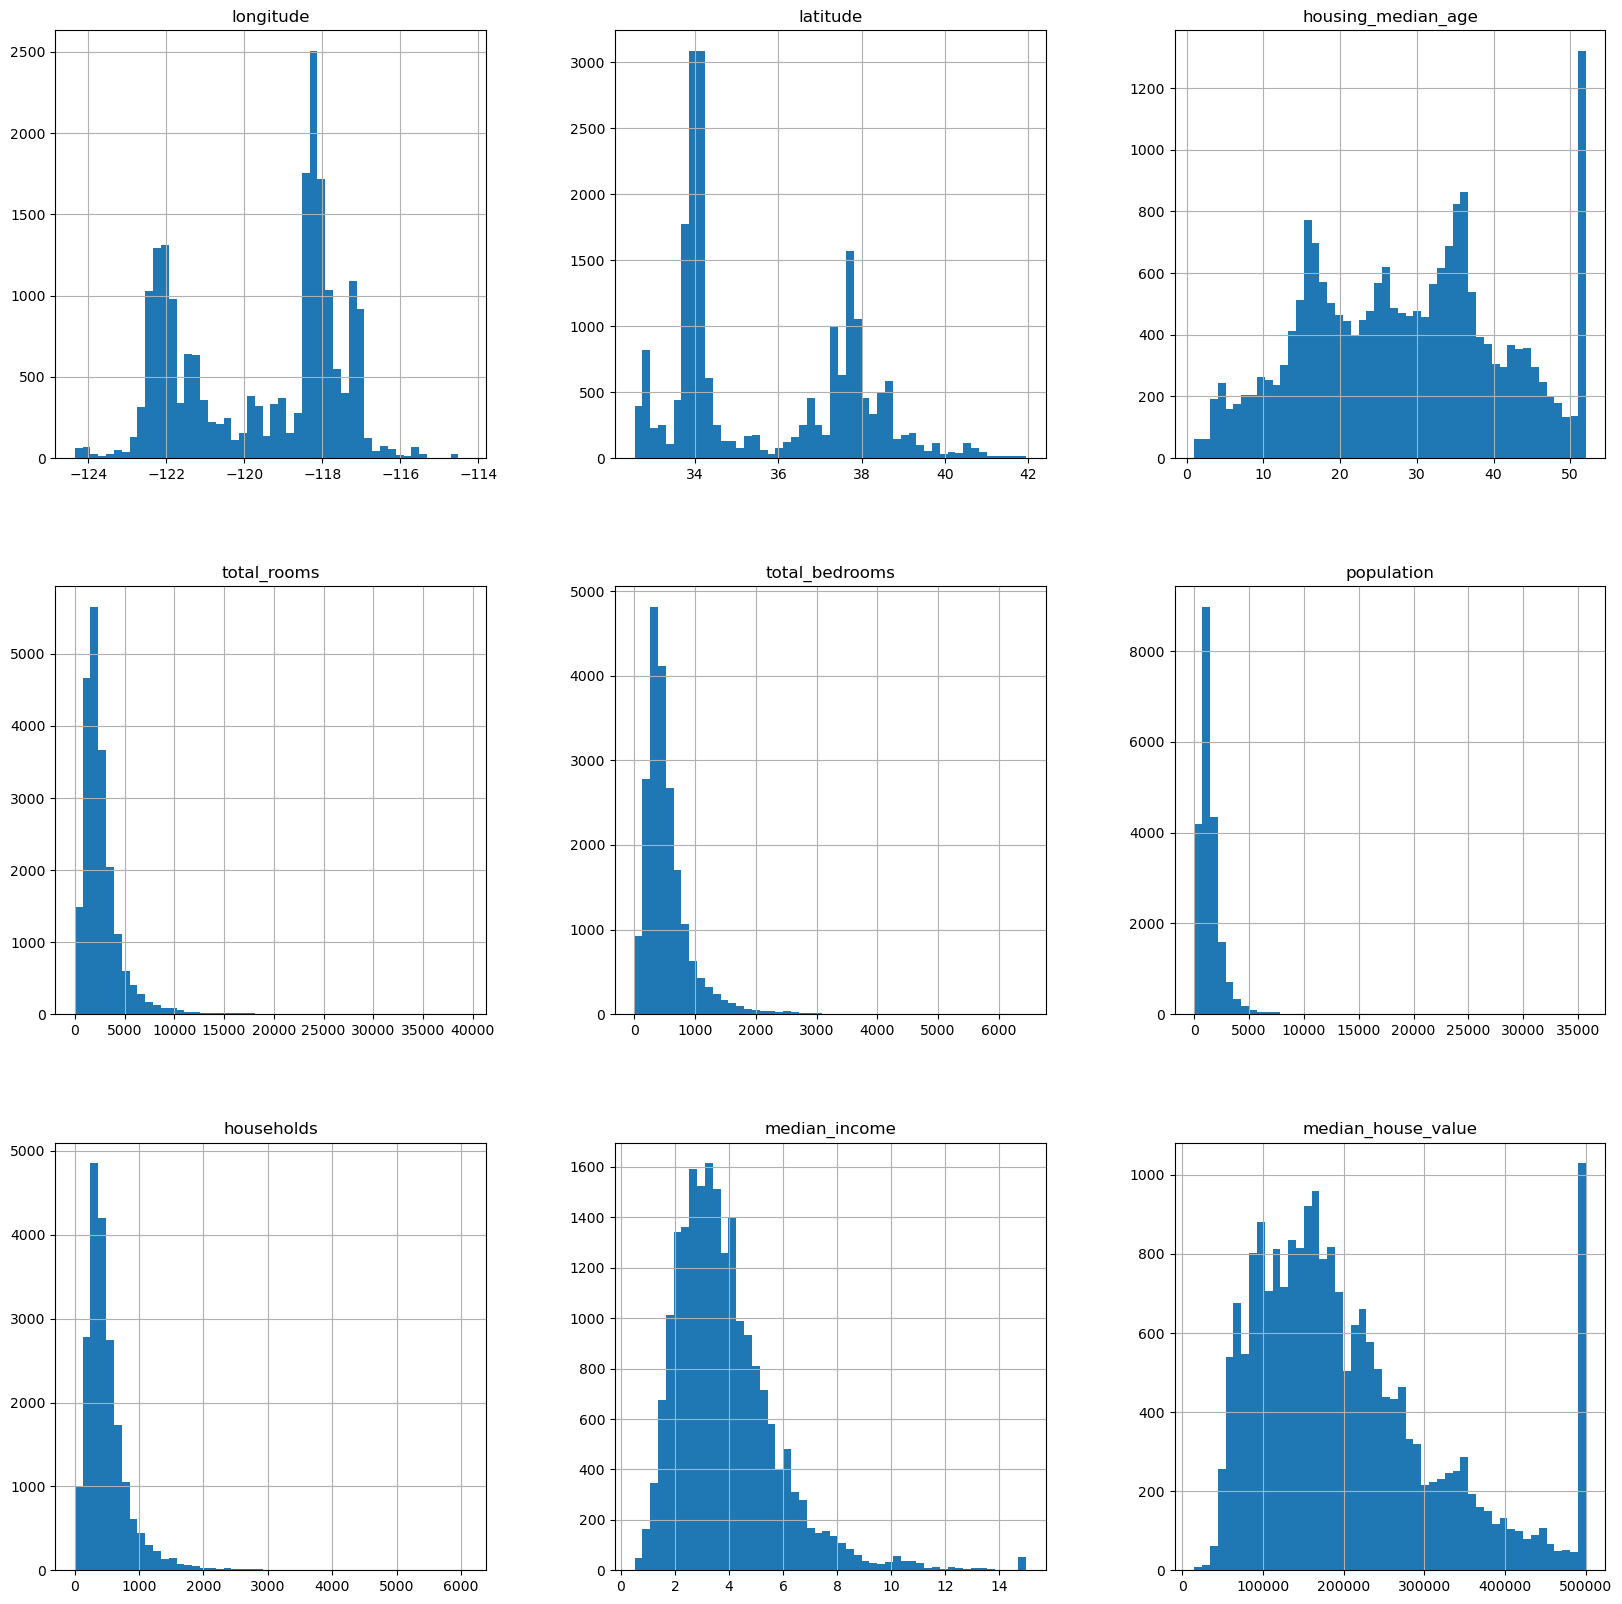

In [18]:
import matplotlib.pyplot as plt
housing_data.hist(bins=50, figsize=(20,20))
plt.show()


To note:

1. It seems there is a cap for median house value, so this would have to be treated in the data preprocessing (add a is_capped flag to these examples)

### Feature correlations

<Axes: >

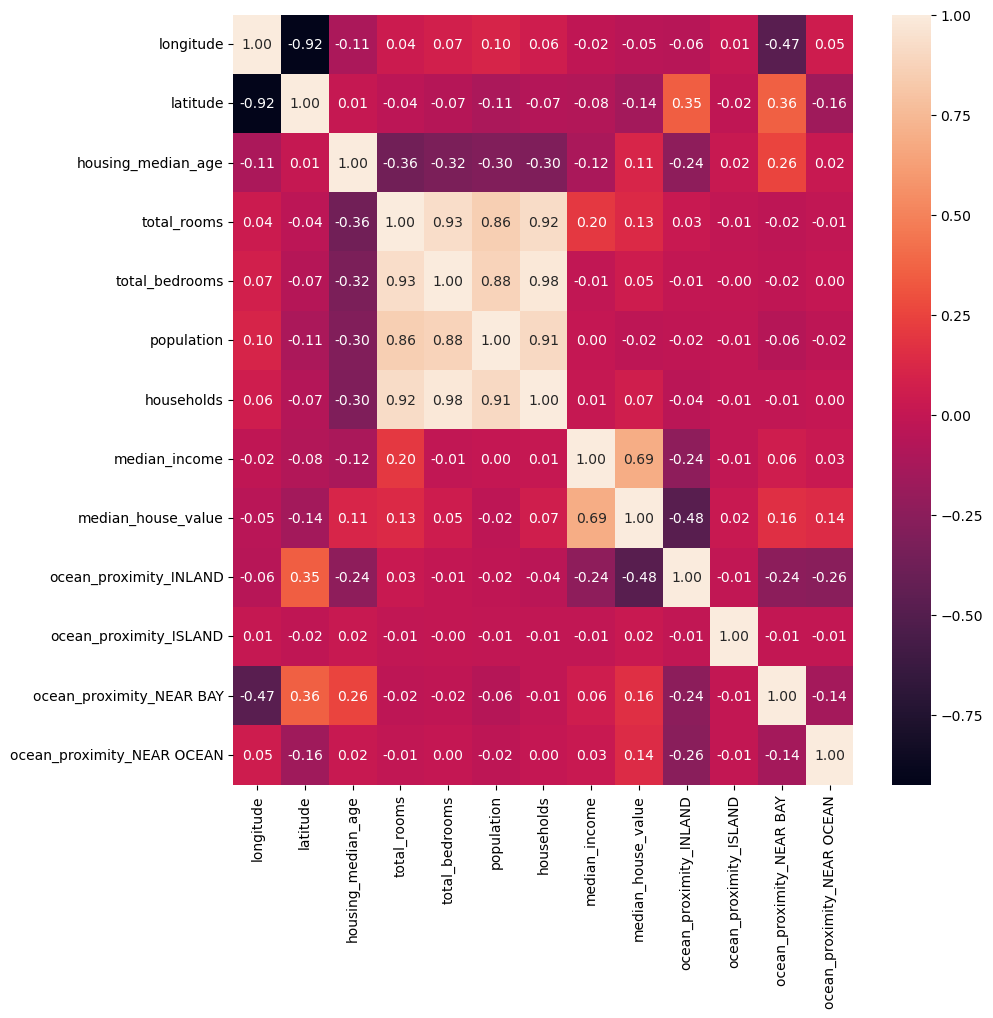

In [5]:
# One hot encoding for categorical field ocean_proximity
housing_data_encoded = pd.get_dummies(housing_data, columns=['ocean_proximity'], drop_first=True)
corr_matrix = housing_data_encoded.corr()

# Visualize correlation matrix (lineal correlations)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

To note:

* We want to predict house value (median_house_value)
* The heatmap shows linear correlations. There may be non-linear correlations that are good features to predict house prices. However, due time constrains, only strong linear correlation will be explored for feature engineering
* The features more correlated to median_house_value are **median_income** and **ocean_proximity_INLAND**

<Axes: xlabel='median_house_value', ylabel='median_income'>

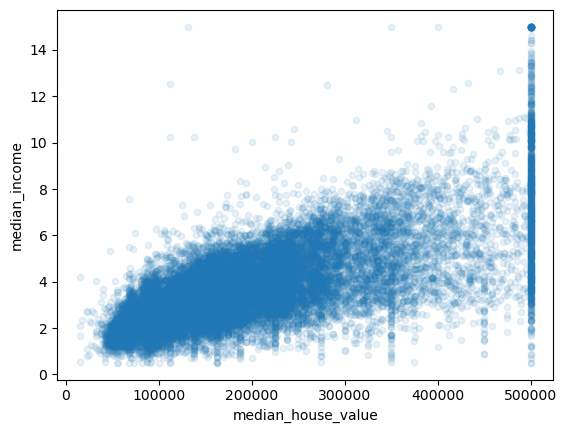

In [6]:
housing_data.plot(kind="scatter", x="median_house_value", y="median_income", alpha=0.1)

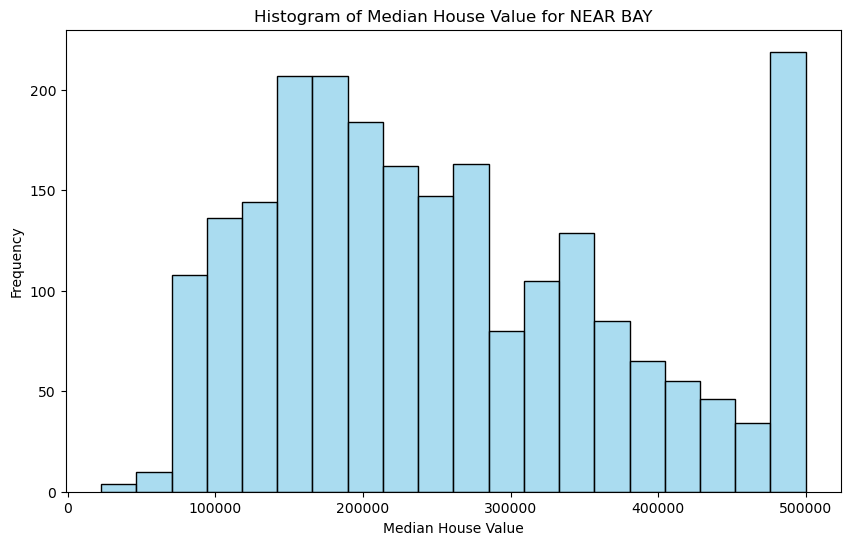

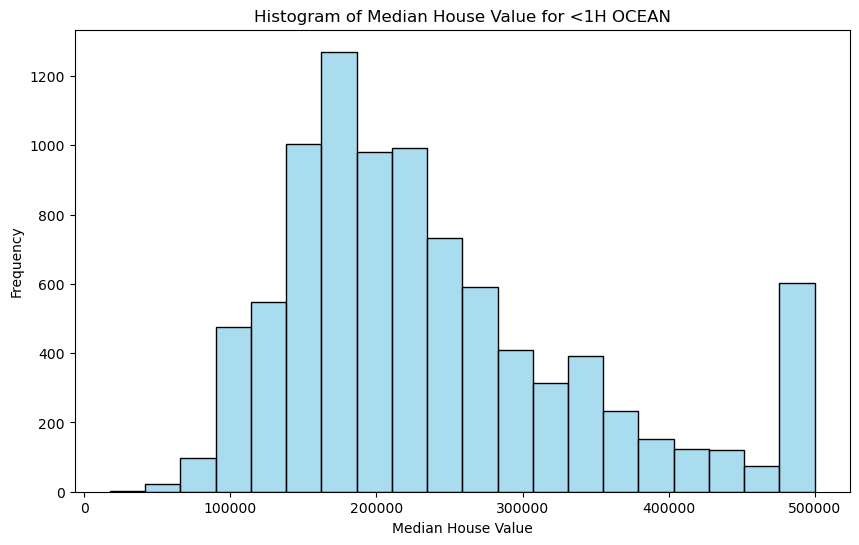

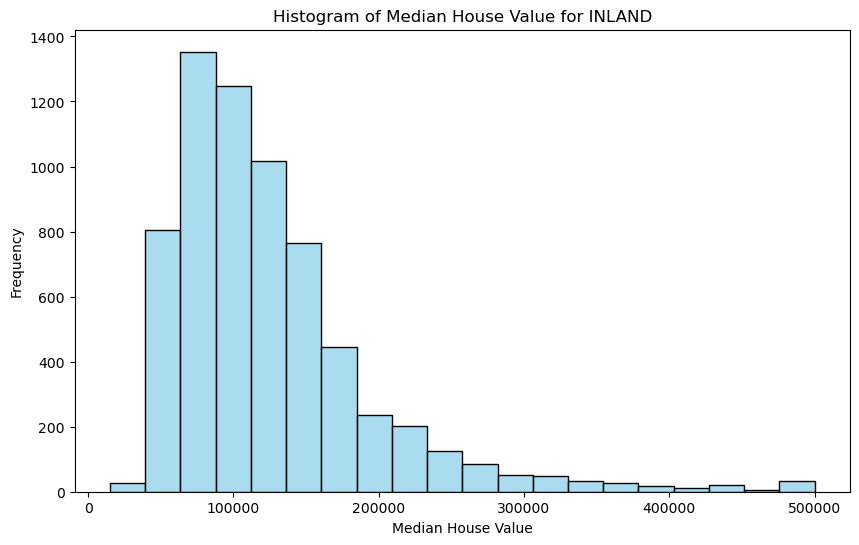

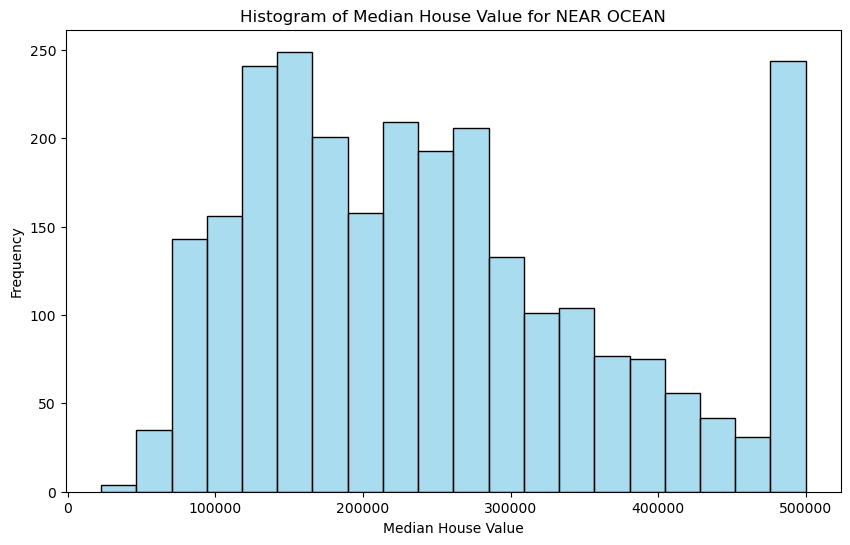

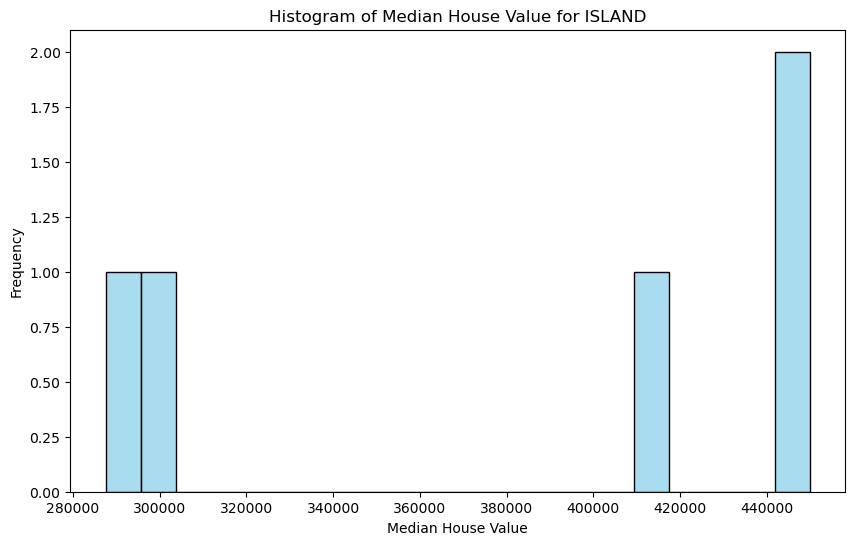

In [7]:
# Create ocean_proximity histograms

categories = housing_data['ocean_proximity'].unique()

# Plot a separate histogram for each category
for category in categories:
    plt.figure(figsize=(10, 6))
    subset = housing_data[housing_data['ocean_proximity'] == category]
    sns.histplot(subset['median_house_value'], bins=20, alpha=0.7, color='skyblue')
    plt.title(f'Histogram of Median House Value for {category}')
    plt.xlabel('Median House Value')
    plt.ylabel('Frequency')
    plt.show()

To note:

1. Some features are skewed to the left/right
2. It seems that some features were capped and there are lots of values at the far-right of plots
3. Housing inland has less value. This is a good feature to predict house value.


### Longitude and Latitude

* A scatter plot with alpha transparency to visualize density in location
* Print the correlation with housing price

<Axes: xlabel='longitude', ylabel='latitude'>

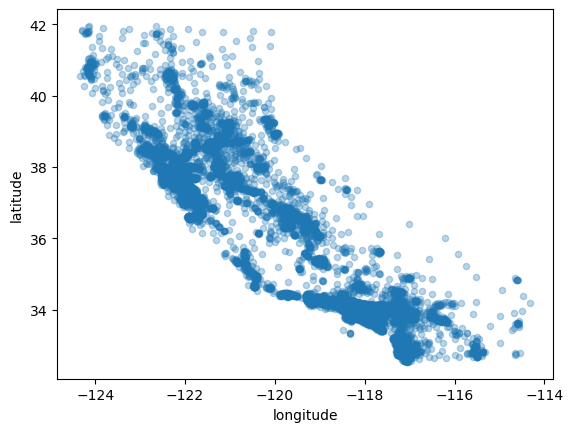

In [8]:

housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3)

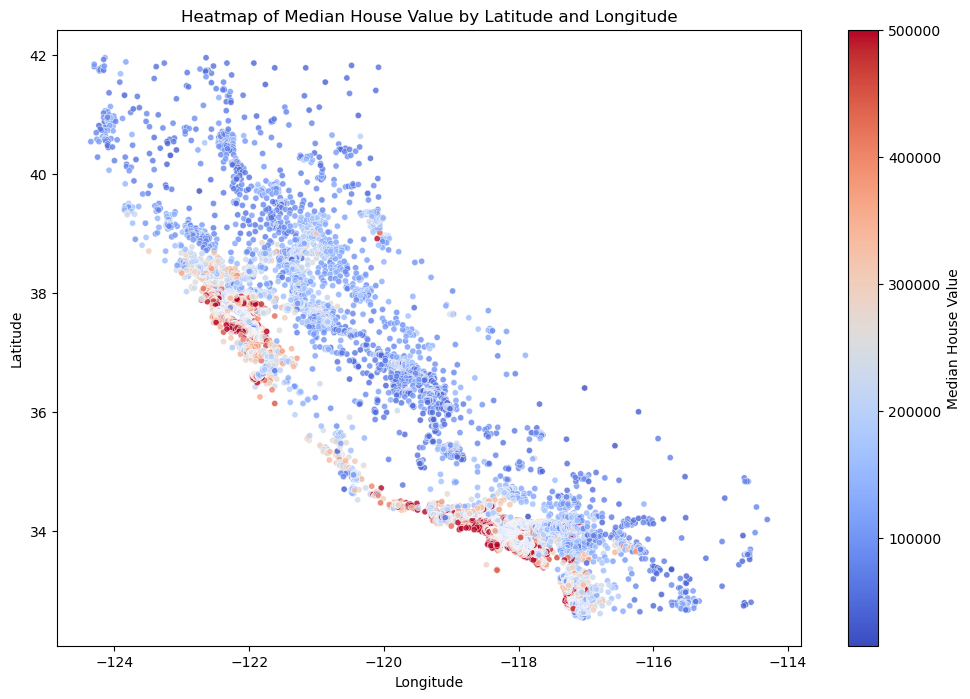

In [9]:
# Create a figure and an axis
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get the current axis

# Create scatter plot with a heatmap effect
scatter = sns.scatterplot(data=housing_data, x='longitude', y='latitude', hue='median_house_value', 
                          palette='coolwarm', size=10, sizes=(20, 200), 
                          alpha=0.8, legend=None, ax=ax)

# Title and labels
plt.title('Heatmap of Median House Value by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show color bar for hue (indicating price levels)
norm = plt.Normalize(housing_data['median_house_value'].min(), housing_data['median_house_value'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Median House Value')

plt.show()

To note:

1. Houses near beaches in certain points are more expensive
2. A useful feature could be the distance between houses and centroids of these clusters

## Data preprocessing and feature engineering

### Create train and test dataset

To note:

1. The dataset is small and a random split could suffer from sampling bias. Due to time constrains, random sampling is done but further testing should be done and use other split strategies if needed (e.g. stratified sampling given a set of categories)

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_data, test_size=0.3, random_state=10)

### Missing values

These can be replaced by mean/median imputation, which should preserve the underlying data distribution
We could build a predictor to model total bedrooms distribution based on other features, but this means another model to train,
test and optimize. 
So for simplicity, median imputation is used. the ratio between missing and non missing (207/20640) is very low so a median
imputation should not add any noise or distribution shifts

In [11]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

train_set['total_bedrooms'] = imputer.fit_transform(train_set[['total_bedrooms']])
test_set['total_bedrooms'] = imputer.transform(test_set[['total_bedrooms']])

print(train_set.isnull().sum())
print("-----------------------------")
print(test_set.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64
-----------------------------
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


## Feature Engineering

### Distance to closest high value area

The reasoning behind this feature is that the closer a house is to areas where the median house value is the highest, the higher the value of the target house will be, as shown by the median housing value heatmap.

To compute this feature, cluster the top 20th percentile of houses and find the centroids, then add the Euclidean distance of each house with respect to the closest centroid as a feature.

In [12]:
from sklearn.cluster import KMeans
import numpy as np

# Calculate the Euclidean distance between two points
def compute_distance(point, centroid):
    return np.sqrt((point[0] - centroid[0])**2 + (point[1] - centroid[1])**2)

# Function to compute the distance to the closest centroid
def distance_to_closest_centroid(row, centroids):
    distances = [compute_distance([row['latitude'], row['longitude']], centroid) for centroid in centroids]
    return min(distances)

# Get the 20th percentile of median house values
threshold = train_set['median_house_value'].quantile(0.80)
high_value_homes = train_set[train_set['median_house_value'] > threshold]

# Compute the KMeans clusters and get the centroids (from the heatmap, we can see there are 2 high value houses clusters)
# Number of clusters
num_clusters = 2

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=10)
high_value_homes['cluster'] = kmeans.fit_predict(high_value_homes[['latitude', 'longitude']])

# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Get the distance to closest centroid to each row in the DataFrame
train_set['distance_to_high_value_area'] = train_set.apply(distance_to_closest_centroid, axis=1, centroids=centroids)

train_set

/tmp/ipykernel_995/2445806097.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_homes['cluster'] = kmeans.fit_predict(high_value_homes[['latitude', 'longitude']])


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,distance_to_high_value_area
17853,-121.88,37.44,23.0,1310.0,267.0,910.0,261.0,5.3994,237900.0,<1H OCEAN,0.331121
15963,-122.44,37.71,52.0,2711.0,591.0,1848.0,524.0,3.9567,251500.0,NEAR BAY,0.290578
20106,-120.29,37.94,17.0,1459.0,297.0,753.0,271.0,3.0500,144800.0,INLAND,1.920634
15525,-117.05,33.14,16.0,4552.0,1166.0,2737.0,1051.0,2.2500,136300.0,<1H OCEAN,1.400175
5234,-118.23,33.94,39.0,1141.0,258.0,1313.0,234.0,2.0187,90100.0,<1H OCEAN,0.046960
...,...,...,...,...,...,...,...,...,...,...,...
9372,-122.53,37.93,37.0,1722.0,352.0,648.0,337.0,4.1250,310300.0,NEAR BAY,0.493029
7291,-118.22,33.98,18.0,1781.0,765.0,1913.0,702.0,1.2059,255000.0,<1H OCEAN,0.087581
17728,-121.79,37.32,6.0,2850.0,561.0,2160.0,581.0,5.5336,241900.0,<1H OCEAN,0.469635
7293,-118.23,33.98,35.0,1366.0,496.0,2160.0,497.0,2.2059,150000.0,<1H OCEAN,0.086959


### Feature relationships

Due time constrains, not all possible meaningful features are explored

In [13]:
from pandas.plotting import scatter_matrix

housing_data_copy = housing_data.copy()
housing_data_copy['bedrooms_per_room'] = housing_data_copy['total_bedrooms'] / housing_data_copy['total_rooms']
housing_data_copy['population_per_household'] = housing_data_copy['population'] / housing_data_copy['households']
housing_data_copy['rooms_per_household'] = housing_data_copy['total_rooms'] / housing_data_copy['households']
housing_data_copy['income_per_household'] = housing_data_copy['median_income'] / housing_data_copy['households']
housing_data_copy['income_per_bedroom'] = housing_data_copy['median_income'] / housing_data_copy['total_bedrooms']
housing_data_copy['income_per_room'] = housing_data_copy['median_income'] / housing_data_copy['total_rooms']
housing_data_copy['age_of_population'] = housing_data_copy['housing_median_age'] / housing_data_copy['population']
housing_data_copy['age_of_households'] = housing_data_copy['housing_median_age'] / housing_data_copy['households']
housing_data_copy['population_density'] = housing_data_copy['population'] / housing_data_copy['total_rooms']
housing_data_copy['bedrooms_per_population'] = housing_data_copy['total_bedrooms'] / housing_data_copy['population']


housing_data_encoded = pd.get_dummies(housing_data_copy, columns=['ocean_proximity'], drop_first=True)
corr_matrix = housing_data_encoded.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)


median_house_value            1.000000
median_income                 0.688075
ocean_proximity_NEAR BAY      0.160284
rooms_per_household           0.151948
ocean_proximity_NEAR OCEAN    0.141862
total_rooms                   0.134153
housing_median_age            0.105623
bedrooms_per_population       0.069896
households                    0.065843
income_per_bedroom            0.057641
income_per_household          0.057479
total_bedrooms                0.049686
income_per_room               0.041348
ocean_proximity_ISLAND        0.023416
age_of_population             0.016970
age_of_households             0.004100
population_per_household     -0.023737
population                   -0.024650
population_density           -0.033557
longitude                    -0.045967
latitude                     -0.144160
bedrooms_per_room            -0.255880
ocean_proximity_INLAND       -0.484859
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='bedrooms_per_room', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='population_per_household', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='rooms_per_household', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='income_per_household', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='income_per_bedroom', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='income_per_room', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='age_of_population', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='age_of_households', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='population_density', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='bedrooms_per_population', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='median_house_value', ylabel='bedrooms_per_room'>],
       [<Axes: xlabel='bedrooms_per_room', ylabel='population_per_household'>,
        <Axes: xlabel='population_per_household', ylabel='population_per_household'>,
        <Axes: xlabel='

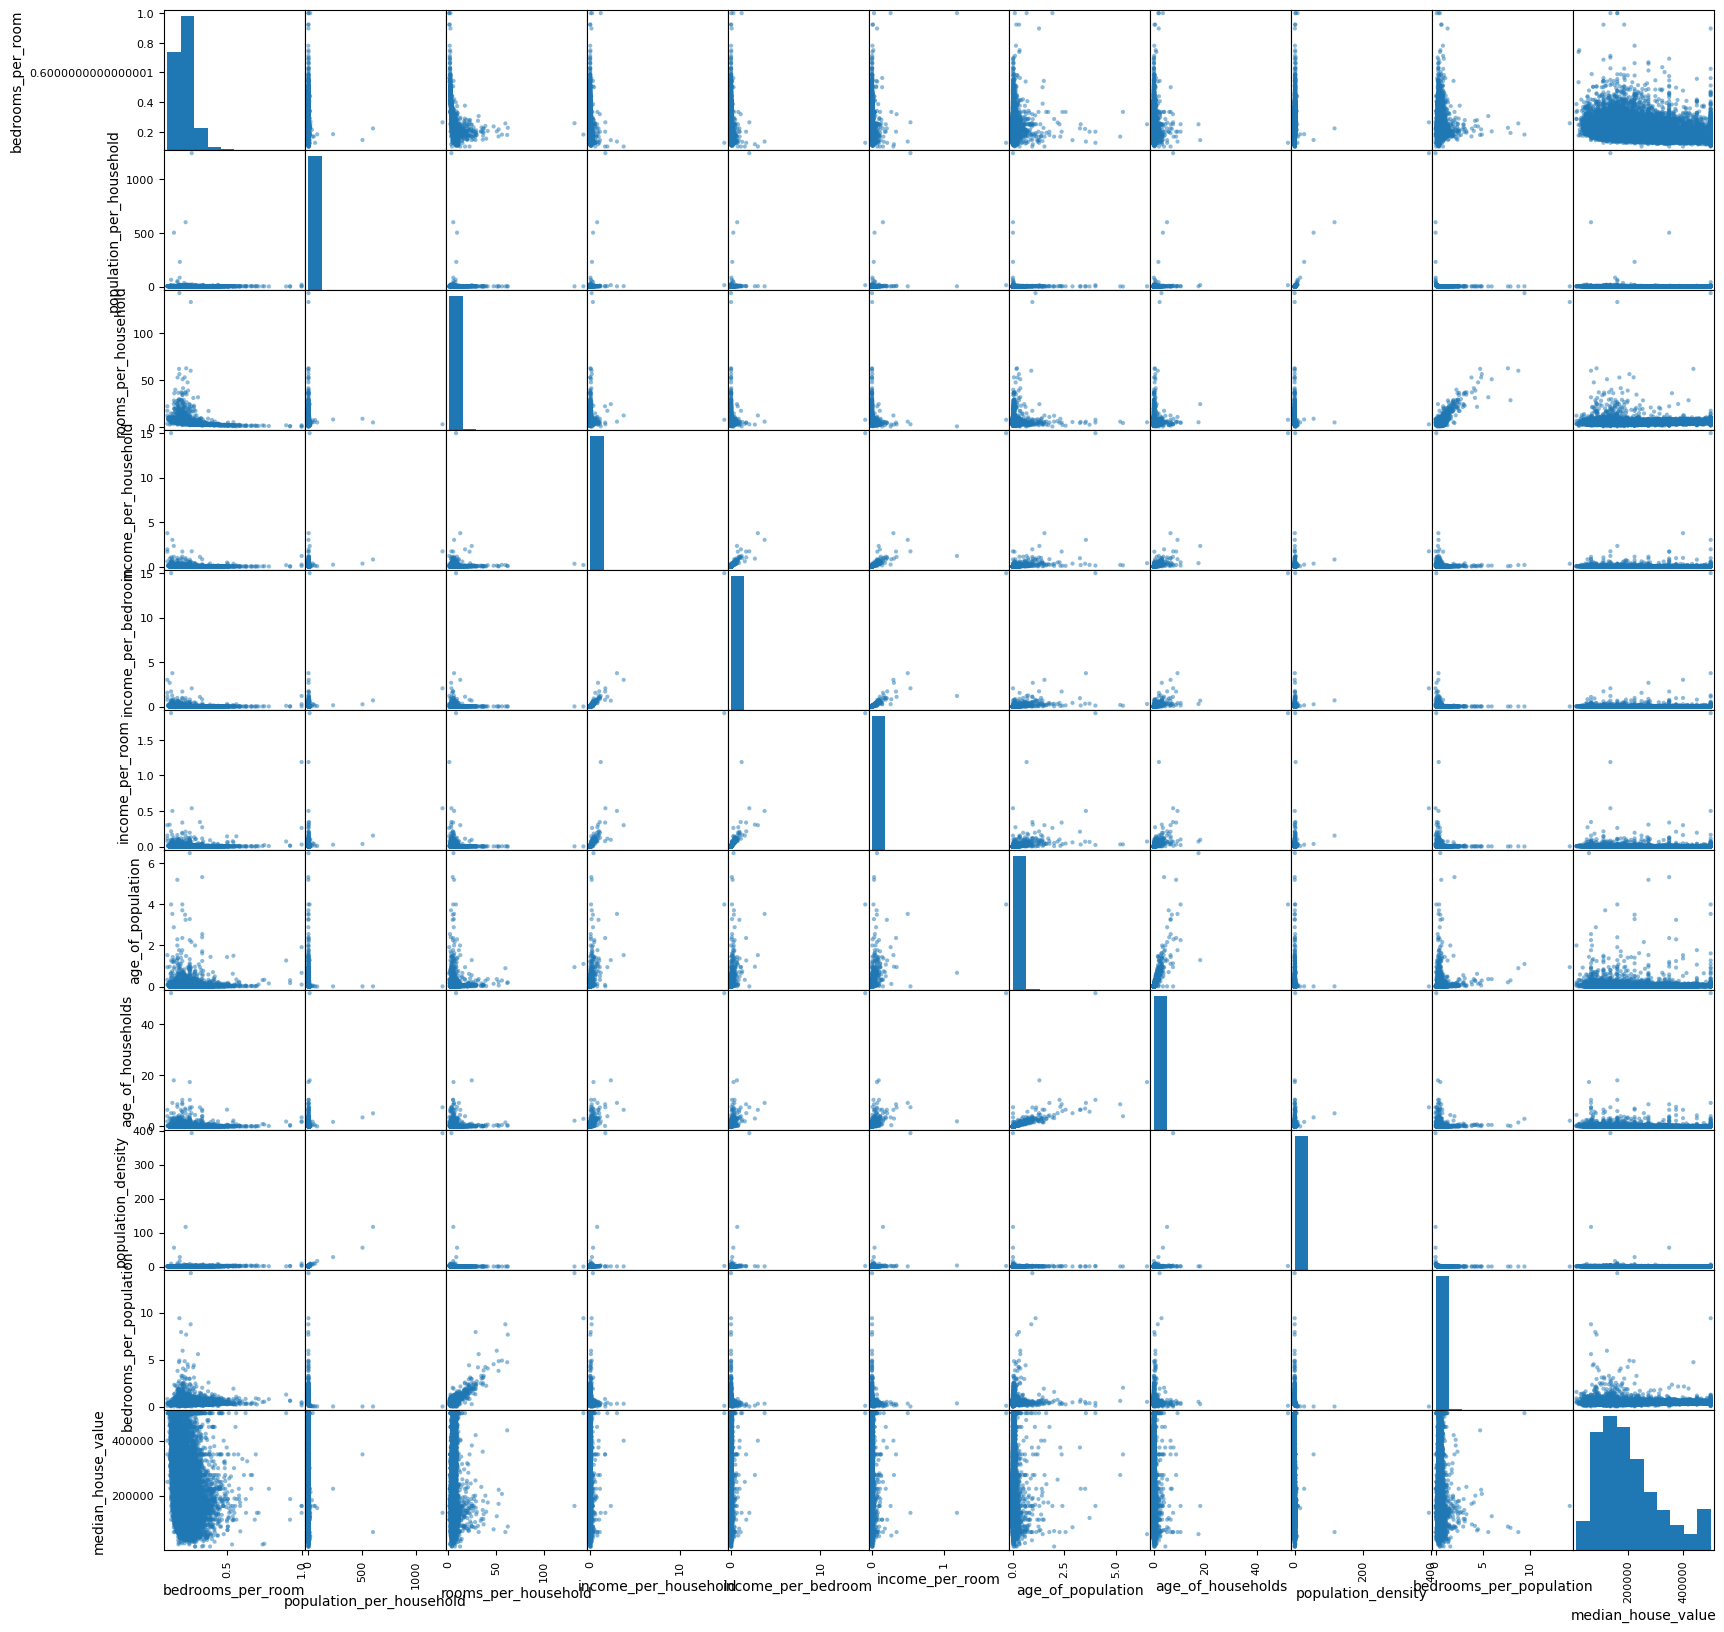

In [14]:
from pandas.plotting import scatter_matrix

attributes = ['bedrooms_per_room', 'population_per_household', 'rooms_per_household', 'income_per_household', 
              'income_per_bedroom', 'income_per_room', 'age_of_population', 'age_of_households', 'population_density', 
              'bedrooms_per_population', 'median_house_value']

scatter_matrix(housing_data_copy[attributes], figsize=(20, 20))

To note:

1. There is some correlation between bedrooms_per_room and rooms_per_houshold w.r.t. median_house_value, though it is not very strong.
2. For the rest of features, the distributions are close to uniform but there could be potentially high order relations not discovered yet, so the features are left. With a tree-based regressor we could do feature importance to see which features should be removed
3. There is correlation between features, this indicates there is redundance in the features. Feature importance in modeling stages should catch this or we could remove them from the dataset directly

## Data pipeline

### Feature engineering

In [15]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.centroids = None


    def __compute_distance(self, point, centroid):
        return np.sqrt((point[0] - centroid[0])**2 + (point[1] - centroid[1])**2)

    def __distance_to_closest_centroid(self, row):
        distances = [self.__compute_distance([row['latitude'], row['longitude']], centroid) for centroid in self.centroids]
        return min(distances)

    def __get_distance_to_high_value_area(self, X):
        if self.centroids is None:
            raise ValueError('Fit the model first before transforming the data')
        
        X['distance_to_high_value_area'] = X.apply(lambda row: self.__distance_to_closest_centroid(row), axis=1)
        return

    # Fit the KMeans clustering model for the distance to high value area feature
    def fit(self, X, y=None, num_clusters=2):
        threshold = X['median_house_value'].quantile(0.80)
        high_value_homes = X[X['median_house_value'] > threshold]

        kmeans = KMeans(n_clusters=num_clusters, random_state=10)
        high_value_homes['cluster'] = kmeans.fit_predict(high_value_homes[['latitude', 'longitude']])
        self.centroids = kmeans.cluster_centers_

        return self
    
    def transform(self, X):
        X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
        X['population_per_household'] = X['population'] / X['households']
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        X['income_per_household'] = X['median_income'] / X['households']
        X['income_per_bedroom'] = X['median_income'] / X['total_bedrooms']
        X['income_per_room'] = X['median_income'] / X['total_rooms']
        X['age_of_population'] = X['housing_median_age'] / X['population']
        X['age_of_households'] = X['housing_median_age'] / X['households']
        X['population_density'] = X['population'] / X['total_rooms']
        X['bedrooms_per_population'] = X['total_bedrooms'] / X['population']
        X['is_capped'] = X['median_house_value'] == 500000
        X['log_median_house_value'] = np.where(X['median_house_value'] < 500000, np.log1p(X['median_house_value']), X['median_house_value'])


        self.__get_distance_to_high_value_area(X)
        
        return X

### Full data pipeline

1. Imputer with the median value for null values
2. Standardize features by removing the mean and scaling to unit variance. So the numerical values will have a normal distribution with 0 mean and 1 variance
3. Change ocean_proximity, which is a categorical feature, to a one-hot encoding.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_data, test_size=0.3, random_state=10)

y_train = train_set['median_house_value']
X_train = train_set.drop('median_house_value', axis=1)

y_test = test_set['median_house_value']
X_test = test_set.drop('median_house_value', axis=1)


num_attribs = train_set.columns.tolist()
num_attribs.remove('ocean_proximity')
cat_attribs = ['ocean_proximity']

# Create a FeatureEngineeringTransformer instance and fit it to the training data (for the centroids estimation) 
feature_eng = FeatureEngineering()
feature_eng.fit(train_set)

num_pipeline = Pipeline([
    ('feature_eng', feature_eng),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

train_set_prepared = pipeline.fit_transform(X_train)
test_set_prepared = pipeline.transform(X_test)


/tmp/ipykernel_995/3837948220.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_homes['cluster'] = kmeans.fit_predict(high_value_homes[['latitude', 'longitude']])
/tmp/ipykernel_995/3837948220.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_homes['cluster'] = kmeans.fit_predict(high_value_homes[['latitude', 'longitude']])


In [17]:
train_set_prepared[0]

array([-1.14723656,  0.83999711, -0.44350528, -0.61468631, -0.64964577,
       -0.45350476, -0.62977912,  0.81227025,  0.27177303, -0.165732  ,
        0.06494541, -0.16664269,  0.03812158,  0.03841391,  0.07184249,
       -0.13469253, -0.05578161,  0.07646402, -0.46989609, -0.66652834,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ])